### MMDetection 설치
* 강의 영상에는 pip install mmcv-full로 mmcv를 설치(약 10분 정도의 시간이 소요)
* 실습코드는 pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu116/torch1.13/index.html 로 변경(설치에 12초 정도 걸림. 2022.09).
* 코랩의 pytorch 버전이 2.0으로 upgrade되었으나 mmdetection은 아직 pytorch 2.0을 지원하지 않기에 pytorch 1.13으로 downgrade 필요(2023.04월에 코랩 pytorch upgrade)
*  2023년 4월 6일 기준으로 mmdetection이 3.0으로 upgrade됨. 실습 코드는 mmdetection 2.x 기준으므로 mmdetection 2.x 소스코드 설치 필요.   

In [ ]:
#코랩의 pytorch 버전이 2.0으로 upgrade됨.
import torch
print(torch.__version__)

1.13.0+cu116


In [ ]:
#현재 mmdetection이 pytorch 2.x를 지원하지 않음. pytorch 1.13+ CUDA 116 환경으로 코랩 커널 downgrade
# downgrade 설치시 ERROR: pip's dependency resolver... 부분은 신경쓰지 않아도 됨.
!pip install -q torch==1.13.0+cu116 torchvision==0.14.0+cu116 --extra-index-url https://download.pytorch.org/whl/cu116

In [ ]:
# mmcv를 위해서 mmcv-full을 먼저 설치해야 함. https://mmcv.readthedocs.io/en/latest/get_started/installation.html 설치 과정 참조.
!pip install -q mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu116/torch1.13/index.html

In [ ]:
# 2023년 4월 6일 기준으로 mmdetection이 3.0으로 upgrade됨. 실습 코드는 mmdetection 2.x 기준임.
# mmdetection 2.x branch의 소스코드 기반으로 mmdetection 설치 필요.
!git clone --branch 2.x https://github.com/open-mmlab/mmdetection.git
!cd mmdetection; python setup.py install

In [ ]:
!pip install -q yapf==0.40.1 # pretty text를 위해서 설치

In [1]:
# 런타임->런타임 다시 시작 후 아래 수행.
from mmdet.apis import init_detector, inference_detector
import mmcv

/usr/local/lib/python3.10/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


### PASCAL VOC 2007 데이터 세트 다운로드

In [ ]:
!wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
!tar -xvf VOCtrainval_06-Nov-2007.tar > /dev/null 2>&1

### MMDetection은 Mask RCNN을 학습하기 위해서는 COCO 포맷을 가장 선호
* CocoDataset으로 지정해야만, evaluation 시 mask evaluation 정보 제공.(2021년 6월 기준) https://mmdetection.readthedocs.io/en/latest/tutorials/customize_dataset.html
* Pascal voc 포맷을 Coco 포맷으로 변환할 수 있는 유틸리티를 활용하여 데이터 변환
https://github.com/ISSResearch/Dataset-Converters
* Dataset converter 패키지가 opencv를 3.4로 downgrade함에 유의

In [5]:
import cv2
print(cv2.__version__)

4.8.0


In [ ]:
!git clone https://github.com/ISSResearch/Dataset-Converters.git
!cd Dataset-Converters; pip install -q -r requirements.txt

In [7]:
!mkdir /content/coco_output
!cd Dataset-Converters;python convert.py --input-folder /content/VOCdevkit/VOC2007 --output-folder /content/coco_output \
                  --input-format VOCSEGM --output-format COCO --copy

In [8]:
!pip install -q opencv-python

### 생성된 Coco Annotation json 파일 살펴 보기

In [ ]:
!sudo apt-get install jq

In [ ]:
!jq . /content/coco_output/annotations/train.json > output.json

In [4]:
!head -20 output.json

{
  "images": [
    {
      "file_name": "000032.jpg",
      "height": 281,
      "width": 500,
      "id": 1
    },
    {
      "file_name": "000033.jpg",
      "height": 366,
      "width": 500,
      "id": 2
    },
    {
      "file_name": "000042.jpg",
      "height": 335,
      "width": 500,
      "id": 3
    },


In [ ]:
!grep -n 'annotations' output.json

1259:  "annotations": [


In [ ]:
!head -1600 output.json | tail -400

      "id": 200
    },
    {
      "file_name": "009654.jpg",
      "height": 500,
      "width": 333,
      "id": 201
    },
    {
      "file_name": "009684.jpg",
      "height": 375,
      "width": 500,
      "id": 202
    },
    {
      "file_name": "009691.jpg",
      "height": 333,
      "width": 500,
      "id": 203
    },
    {
      "file_name": "009709.jpg",
      "height": 500,
      "width": 375,
      "id": 204
    },
    {
      "file_name": "009756.jpg",
      "height": 375,
      "width": 500,
      "id": 205
    },
    {
      "file_name": "009807.jpg",
      "height": 333,
      "width": 500,
      "id": 206
    },
    {
      "file_name": "009832.jpg",
      "height": 375,
      "width": 500,
      "id": 207
    },
    {
      "file_name": "009911.jpg",
      "height": 400,
      "width": 500,
      "id": 208
    },
    {
      "file_name": "009938.jpg",
      "height": 375,
      "width": 500,
      "id": 209
    }
  ],
  "type": "instances",
  "annotations": [
    

### Pretrained 모델 다운로드 및 Config, Dataset설정.

In [2]:
# pretrained weight 모델을 다운로드 받기 위해서 mmdetection/checkpoints 디렉토리를 만듬.
!cd mmdetection; mkdir checkpoints

In [3]:
!wget -O /content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth http://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r101_fpn_1x_coco/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth

--2023-11-19 11:37:14--  http://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r101_fpn_1x_coco/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.246.48.207, 47.246.48.204, 47.246.48.209, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|47.246.48.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 254089599 (242M) [application/octet-stream]
Saving to: ‘/content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth’

/content/mmdetectio 100%[===================>] 242.32M  27.3MB/s    in 9.4s    

2023-11-19 11:37:24 (25.7 MB/s) - ‘/content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth’ saved [254089599/254089599]



In [4]:
!ls -lia /content/mmdetection/checkpoints

total 248144
2243916 drwxr-xr-x  2 root root      4096 Nov 19 10:55 .
2228335 drwxr-xr-x 19 root root      4096 Nov 19 10:55 ..
2243917 -rw-r--r--  1 root root 254089599 Nov  2  2021 mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth


In [3]:
# config 파일을 설정하고, 다운로드 받은 pretrained 모델을 checkpoint로 설정.
config_file = '/content/mmdetection/configs/mask_rcnn/mask_rcnn_r101_fpn_1x_coco.py'
checkpoint_file = '/content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth'

In [3]:
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.coco import CocoDataset

@DATASETS.register_module(force=True)
class VOCDataset(CocoDataset):
  CLASSES = ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car',
               'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train',
               'tvmonitor')

In [6]:
from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

model = dict(
    type='MaskRCNN',
    backbone=dict(
        type='ResNet',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained',
                      checkpoint='torchvision://resnet101')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoi

In [14]:
from mmdet.apis import set_random_seed

# dataset에 대한 환경 파라미터 수정.
cfg.dataset_type = 'VOCDataset'
cfg.data_root = '/content/coco_output/'

# train, val, test dataset에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정.
cfg.data.train.type = 'VOCDataset'
cfg.data.train.data_root = '/content/coco_output/'
cfg.data.train.ann_file = 'annotations/train.json'
cfg.data.train.img_prefix = 'train'

cfg.data.val.type = 'VOCDataset'
cfg.data.val.data_root = '/content/coco_output/'
cfg.data.val.ann_file = 'annotations/val.json'
cfg.data.val.img_prefix = 'val'


# class의 갯수를 pascal voc로 설정.  수정.
cfg.model.roi_head.bbox_head.num_classes = 20
cfg.model.roi_head.mask_head.num_classes = 20

# pretrained 모델
cfg.load_from = '/content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth'

# 학습 weight 파일로 로그를 저장하기 위한 디렉토리 설정.
cfg.work_dir = './tutorial_exps'

# 학습율 변경 환경 파라미터 설정.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 12

# CocoDataset의 경우 metric을 bbox로 설정해야 함.(mAP아님. bbox로 설정하면 mAP를 iou threshold를 0.5 ~ 0.95까지 변경하면서 측정)
cfg.evaluation.metric = ['bbox', 'segm']
cfg.evaluation.interval = 12
cfg.checkpoint_config.interval = 12
cfg.runner.max_epochs = 12

# 두번 config를 로드하면 lr_config의 policy가 사라지는 오류로 인하여 설정.
cfg.lr_config.policy='step'
# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# ConfigDict' object has no attribute 'device 오류 발생시 반드시 설정 필요. https://github.com/open-mmlab/mmdetection/issues/7901
cfg.device='cuda'

In [8]:
print(cfg.pretty_text)

model = dict(
    type='MaskRCNN',
    backbone=dict(
        type='ResNet',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained',
                      checkpoint='torchvision://resnet101')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoi

In [9]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# train용 Dataset 생성.
datasets = [build_dataset(cfg.data.train)]

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [10]:
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
model.CLASSES = datasets[0].CLASSES
print(model.CLASSES)

('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')


In [11]:
import os.path as osp
import mmcv

mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
# epochs는 config의 runner 파라미터로 지정됨. 기본 12회에서 20회로 바꿈
train_detector(model, datasets, cfg, distributed=False, validate=True)

2023-11-19 12:21:35,095 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2023-11-19 12:21:35,129 - mmdet - INFO - load checkpoint from local path: /content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


2023-11-19 12:21:35,423 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([21, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([21]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([80, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([80]).
size mismatch for roi_head.mask_head.conv_logits.weight: copying a param with shape torch.Size([80, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([20, 256, 1, 1]).
size mismatch for roi_head.mask_head.conv_logits

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 213/213, 5.7 task/s, elapsed: 38s, ETA:     0s

2023-11-19 12:41:35,147 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2023-11-19 12:41:35,559 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.499
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.785
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.591
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.262
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.505
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.565
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.607
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.607
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.607
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.326
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.615
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.21s).
Accumulating evaluation results...
DONE (t=0.18s).
Loading and preparing results...


/usr/local/lib/python3.10/dist-packages/mmdet-2.28.2-py3.10.egg/mmdet/datasets/coco.py:470: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(


DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.28s).
Accumulating evaluation results...


2023-11-19 12:41:36,126 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.460
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.724
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.508
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.166
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.416
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.582
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.558
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.558
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.558
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.231
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.529
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.24s).


### 학습된 모델을 이용하여 단일 이미지와 Video Inference 수행.

load checkpoint from local path: /content/tutorial_exps/epoch_12.pth


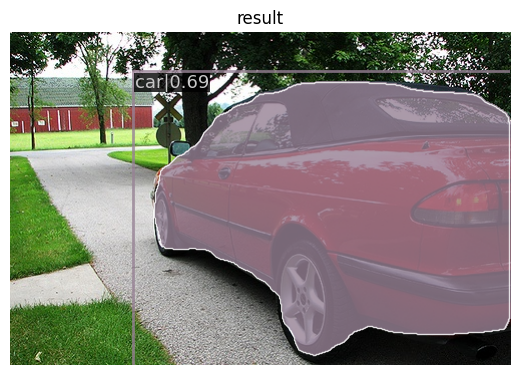

In [19]:
# 에포크 20인데도 마스킹을 하나도 못함
from mmdet.apis import show_result_pyplot

checkpoint_file = '/content/tutorial_exps/epoch_12.pth'

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용.
model_ckpt = init_detector(cfg, checkpoint_file, device='cuda:0')
# BGR Image 사용
img = cv2.imread('/content/VOCdevkit/VOC2007/JPEGImages/000007.jpg')
#model_ckpt.cfg = cfg

result = inference_detector(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, score_thr=0.65)

### Video Inference 수행
* get_detected_img()함수를 이용하여 Inference 수행.

In [20]:
!wget -O /content/data/London_Street.mp4 https://github.com/chulminkw/DLCV/blob/master/data/video/London_Street.mp4?raw=true

--2023-11-19 12:46:35--  https://github.com/chulminkw/DLCV/blob/master/data/video/London_Street.mp4?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/chulminkw/DLCV/raw/master/data/video/London_Street.mp4 [following]
--2023-11-19 12:46:35--  https://github.com/chulminkw/DLCV/raw/master/data/video/London_Street.mp4
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/London_Street.mp4 [following]
--2023-11-19 12:46:35--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/London_Street.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443..

In [21]:
import numpy as np

labels_to_names_seq =  {0:'aeroplane', 1:'bicycle', 2:'bird', 3:'boat', 4:'bottle', 5:'bus', 6:'car',
               7:'cat', 8:'chair', 9:'cow', 10:'diningtable', 11:'dog', 12:'horse',
               13:'motorbike', 14:'person', 15:'pottedplant', 16:'sheep', 17:'sofa', 18:'train',
               19:'tvmonitor'}

colors = list(
    [[0, 255, 0],
     [0, 0, 255],
     [255, 0, 0],
     [0, 255, 255],
     [255, 255, 0],
     [255, 0, 255],
     [80, 70, 180],
     [250, 80, 190],
     [245, 145, 50],
     [70, 150, 250]] )

In [22]:
# model과 원본 이미지 array, filtering할 기준 class confidence score를 인자로 가지는 inference 시각화용 함수 생성.
# 이미 inference 시 mask boolean값이 들어오므로 mask_threshold 값을 필요하지 않음.
def get_detected_img(model, img_array,  score_threshold=0.3, is_print=True):
  # 인자로 들어온 image_array를 복사.
  draw_img = img_array.copy()
  bbox_color=(0, 255, 0)
  text_color=(0, 0, 255)

  # model과 image array를 입력 인자로 inference detection 수행하고 결과를 results로 받음.
  # results는 80개의 2차원 array(shape=(오브젝트갯수, 5))를 가지는 list.
  results = inference_detector(model, img_array)
  bbox_results = results[0]
  seg_results = results[1]

  # 80개의 array원소를 가지는 results 리스트를 loop를 돌면서 개별 2차원 array들을 추출하고 이를 기반으로 이미지 시각화
  # results 리스트의 위치 index가 바로 COCO 매핑된 Class id. 여기서는 result_ind가 class id
  # 개별 2차원 array에 오브젝트별 좌표와 class confidence score 값을 가짐.
  for result_ind, bbox_result in enumerate(bbox_results):
    # 개별 2차원 array의 row size가 0 이면 해당 Class id로 값이 없으므로 다음 loop로 진행.
    if len(bbox_result) == 0:
      continue

    mask_array_list = seg_results[result_ind]

    # 해당 클래스 별로 Detect된 여러개의 오브젝트 정보가 2차원 array에 담겨 있으며, 이 2차원 array를 row수만큼 iteration해서 개별 오브젝트의 좌표값 추출.
    for i in range(len(bbox_result)):
      # 좌상단, 우하단 좌표 추출.
      if bbox_result[i, 4] > score_threshold:
        left = int(bbox_result[i, 0])
        top = int(bbox_result[i, 1])
        right = int(bbox_result[i, 2])
        bottom = int(bbox_result[i, 3])
        caption = "{}: {:.4f}".format(labels_to_names_seq[result_ind], bbox_result[i, 4])
        cv2.rectangle(draw_img, (left, top), (right, bottom), color=bbox_color, thickness=2)
        cv2.putText(draw_img, caption, (int(left), int(top - 7)), cv2.FONT_HERSHEY_SIMPLEX, 0.37, text_color, 1)
        # masking 시각화 적용. class_mask_array는 image 크기 shape의  True/False값을 가지는 2차원 array
        class_mask_array = mask_array_list[i]
        # 원본 image array에서 mask가 True인 영역만 별도 추출.
        masked_roi = draw_img[class_mask_array]
        #color를 임의 지정
        #color_index = np.random.randint(0, len(colors)-1)
        # color를 class별로 지정
        color_index = result_ind % len(colors)
        color = colors[color_index]
        # apply_mask()함수를 적용시 수행 시간이 상대적으로 오래 걸림.
        #draw_img = apply_mask(draw_img, class_mask_array, color, alpha=0.4)
        # 원본 이미지의 masking 될 영역에 mask를 특정 투명 컬러로 적용
        draw_img[class_mask_array] = ([0.3*color[0], 0.3*color[1], 0.3*color[2]] + 0.6 * masked_roi).astype(np.uint8)
        if is_print:
          print(caption)

  return draw_img


In [23]:
import time

def do_detected_video(model, input_path, output_path, score_threshold, do_print=True):

    cap = cv2.VideoCapture(input_path)

    codec = cv2.VideoWriter_fourcc(*'XVID')

    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)

    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size)

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt)
    btime = time.time()
    while True:
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break
        stime = time.time()
        img_frame = get_detected_img(model, img_frame,  score_threshold=score_threshold,is_print=False)
        if do_print:
          print('frame별 detection 수행 시간:', round(time.time() - stime, 4))
        vid_writer.write(img_frame)
    # end of while loop

    vid_writer.release()
    cap.release()

    print('최종 detection 완료 수행 시간:', round(time.time() - btime, 4))

In [24]:
do_detected_video(model_ckpt, '/content/data/London_Street.mp4', '/content/data/London_Street_out01.mp4', score_threshold=0.65, do_print=True)

총 Frame 갯수: 489
frame별 detection 수행 시간: 0.3194
frame별 detection 수행 시간: 0.2654
frame별 detection 수행 시간: 0.2565
frame별 detection 수행 시간: 0.2666
frame별 detection 수행 시간: 0.2706
frame별 detection 수행 시간: 0.2712
frame별 detection 수행 시간: 0.2768
frame별 detection 수행 시간: 0.268
frame별 detection 수행 시간: 0.2712
frame별 detection 수행 시간: 0.2675
frame별 detection 수행 시간: 0.2704
frame별 detection 수행 시간: 0.2759
frame별 detection 수행 시간: 0.277
frame별 detection 수행 시간: 0.3093
frame별 detection 수행 시간: 0.3063
frame별 detection 수행 시간: 0.2829
frame별 detection 수행 시간: 0.2743
frame별 detection 수행 시간: 0.2725
frame별 detection 수행 시간: 0.2816
frame별 detection 수행 시간: 0.2826
frame별 detection 수행 시간: 0.2755
frame별 detection 수행 시간: 0.2751
frame별 detection 수행 시간: 0.2757
frame별 detection 수행 시간: 0.2739
frame별 detection 수행 시간: 0.3257
frame별 detection 수행 시간: 0.3471
frame별 detection 수행 시간: 0.3358
frame별 detection 수행 시간: 0.3227
frame별 detection 수행 시간: 0.319
frame별 detection 수행 시간: 0.319
frame별 detection 수행 시간: 0.3168
frame별 detection 수행 시간: 0.3